In [43]:
import json
import os

import numpy as np
import torch
from matplotlib import pyplot as plt

from kwave.ktransducer import *
from utils.data import load_mat
import torch
from torch import nn

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = './data/'
np.array([0])

array([0])

In [44]:
class DAS(nn.Module):
    """Delay-And-Sum image reconstruction module Photoacoustic Computed Tomography with ring array ."""
    def __init__(self, R_ring, N_transducer, T_sample, v0, x_vec, y_vec, mode='zero', clip=False):
        """Initialize parameters of the Delay-And-Sum module.

        Args:
            R_ring (`float`): Raduis of the ring transducer array.
            N_transducer (`int`): Number of uniformly distributed transducers in the ring array.
            T_sample (`float`): Sample time interval [s].
            v0 (`float`): Speed of sound [m/s].
            x_vec (`numpy.ndarray`): X coordinates of the image grid.
            y_vec (`numpy.ndarray`): Y coordinates of the image grid.
            mode (str, optional): _description_. Defaults to `zero`.
            clip (bool, optional): Whether to clip the time index into the time range of the sinogram. Defaults to `False` to accelerate the reconstruction.
        """
        super(DAS, self).__init__()
        
        self.R_ring = torch.tensor(R_ring)
        self.N_transducer = N_transducer
        self.T_sample = torch.tensor(T_sample)
        self.v0 = torch.tensor(v0)
        self.x_vec = torch.tensor(x_vec).view(1, -1, 1)
        self.y_vec = torch.tensor(y_vec).view(1, 1, -1)
        self.H, self.W = self.x_vec.shape[1], self.y_vec.shape[2]
        self.mode = mode
        self.clip = clip
        
        angle_transducer = 2 * torch.pi / self.N_transducer * (torch.arange(self.N_transducer) + 1).view(-1, 1, 1)
        self.x_transducer = self.R_ring * torch.cos(angle_transducer - torch.pi)
        self.y_transducer = self.R_ring * torch.sin(angle_transducer - torch.pi)
        self.distance_to_transducer = torch.sqrt((self.x_transducer - self.x_vec)**2 + (self.y_transducer - self.y_vec)**2)
        self.id_transducer = torch.arange(self.N_transducer).view(self.N_transducer,1,1).repeat(1,self.H,self.W)

    def forward(self, sinogram, d_delay=torch.zeros(1), ring_error=torch.zeros(1)):
        if sinogram.shape[0] != self.N_transducer:
            raise ValueError('Invalid number of transducer in the sinogram.')
        
        if self.mode == 'zero':
            sinogram[:, 0] = 0
            sinogram[:, -1] = 0
        
        id_time = torch.round((self.distance_to_transducer - d_delay + ring_error) / (self.v0 * self.T_sample)).int()
        if self.clip:
            id_time = id_time.maximum(torch.zeros_like(id_time)).minimum(torch.ones_like(id_time) * (sinogram.shape[1]-1))
       
        return sinogram[self.id_transducer, id_time].mean(0)

In [45]:
sinogram_uniform = load_mat(os.path.join(data_path, 'sinogram_simulation_uniform.mat'))
sinogram_uniform = torch.from_numpy(sinogram_uniform).float().to(device)
sinogram_uniform.shape

torch.Size([512, 2000])

In [46]:
Nx, Ny = 560, 560
R_ring = 0.05   # Radius of the ring array [m].
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

In [47]:
model = DAS(0.05, 512, 1/(40e6), 1508, kgrid.x_vec[:], kgrid.y_vec[:], mode='zero')
model.to(device)
model.eval()

DAS()

In [48]:
with torch.no_grad():
    img = model(sinogram_uniform)

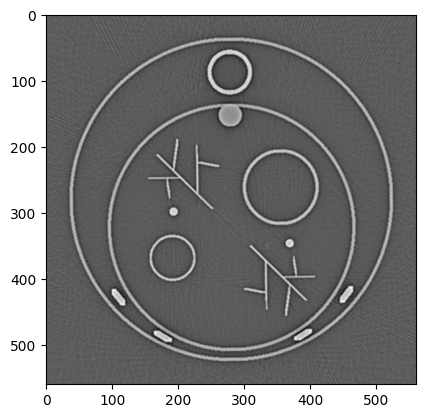

In [49]:
plt.imshow(img.cpu().detach().numpy(), cmap='gray')